In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import numpy as np
# sns.set()

In [87]:
from matplotlib import rcParams
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['font.family'] = 'serif'

### Load data

In [89]:
data = pd.read_csv("Marketing_data_clustered.csv")

### PCA for 3D graph

In [90]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select numerical features for PCA (excluding 'Cluster')
numerical_features = [
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'
]

# Standardize features before applying PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_features])

# Apply PCA
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

# Add PCA columns to the dataset
data['PCA1'] = pca_components[:, 0]
data['PCA2'] = pca_components[:, 1]
data['PCA3'] = pca_components[:, 2]

In [91]:
# Calculate cluster-wise means for bar charts
cluster_means = data.groupby('cluster').mean().reset_index()

# scaled data
df = pd.DataFrame(data=scaled_data, columns=numerical_features)
df['cluster'] = data['cluster']
cluster_means_scaled = df.groupby('cluster').mean().reset_index()

In [92]:
# Cluster names and marketing strategies
cluster_strategies = {
    0: "Potential approach: Promote alternatives to cash advances, provide exclusive \noffers, and offer financial management tools.",
    1: "Potential approach: Encourage spending with cashback and loyalty rewards, \noffer gradual credit limit increases, and promote financial education.",
    2: "Potential approach: Upsell premium credit cards, offer flexible financing, \npersonalize rewards, and cross-sell additional financial products",
    3: "Potential approach: Introduce premium rewards, offer personalized financial \nservices, implement VIP engagement strategies, and suggest targeted investment opportunities",
}

cluster_names = {0: ['Cash Advance Enthusiasts', 'Low Spend, High Balance, High Credit'],
                 1: ['Frugal Clients', 'Low Spend, Low Balance'],
                 2: ['Balanced Spenders', 'High Spend, Moderate Balance'],
                 3: ['Luxury Seekers', 'High Spend, High Balance, High Credit']}

percent = {0: '12,4%',
           1: '69,5%',
           2: '16,7%',
           3: '1,4%'}

In [93]:
colors = ['#80BCBD', '#78B3CE', '#f599c3', '#A888B5']

### 3D pca graph

In [94]:

# Function to create the PCA scatter plot
def plot_pca(ax, cluster_id, alpha_cluster, aplha_all):
    global colors
    for i, color in enumerate(colors):
        subset = data[data['cluster'] == i]
        ax.scatter(subset['PCA1'], subset['PCA2'],  subset['PCA3'],
                   color=color if i == cluster_id else "#b9c0c6",
                   alpha=alpha_cluster if i == cluster_id else aplha_all,
                   label=f"Cluster {i}",
                   s=110)

    ax.view_init(elev=5, azim=290)
    # Hide tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # Disable gridlines
    ax.grid(False)

    # Hide 3D axes by setting pane and axis line visibility
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = True


    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.set_ticklabels([])
        axis._axinfo['axisline']['linewidth'] = 0.5
        axis._axinfo['axisline']['color'] = (0, 0, 0)
        axis._axinfo['grid']['linewidth'] = 0.5
        axis._axinfo['grid']['linestyle'] = "-"
        axis._axinfo['grid']['color'] = (0, 0, 0)
        axis._axinfo['tick']['inward_factor'] = 0.0
        axis._axinfo['tick']['outward_factor'] = 0.0
        axis.set_pane_color((0.95, 0.95, 0.95))

    ax.zaxis.pane.set_facecolor((0.87, 0.87, 0.87, 0.2))
    ax.xaxis.pane.set_facecolor((0.93, 0.93, 0.93, 0.2))

### Radar chart


In [95]:
import matplotlib.transforms as mtransforms

def radar_chart(ax, cluster_id, next_cluster_id, step, total_steps):
    global colors
    # Get current and next cluster's values
    cluster_current = cluster_means_scaled[cluster_means_scaled['cluster'] == cluster_id]
    cluster_next = cluster_means_scaled[cluster_means_scaled['cluster'] == next_cluster_id]

    labels = ['BALANCE', 'BALANCE_FREQUENCY', 'CASH_ADVANCE',
              'CASH_ADVANCE_FREQUENCY', 'PURCHASES', 'PURCHASES_FREQUENCY']
    stats_current = cluster_current[labels].values[0]
    stats_next = cluster_next[labels].values[0]

    # Interpolate values based on the current step
    interpolation = step / total_steps
    stats_interpolated = stats_current * (1 - interpolation) + stats_next * interpolation

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

    # Ensure both stats and angles are closed for the radar chart
    stats_interpolated = np.concatenate((stats_interpolated, [stats_interpolated[0]]))
    angles += [angles[0]]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.fill(angles, stats_interpolated, color=colors[cluster_id], alpha=0.3)
    ax.plot(angles, stats_interpolated, color=colors[cluster_id], linewidth=2)

    # Add feature labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=12)
    ax.set_ylim(-5, 5)



In [ ]:
### Complete chart

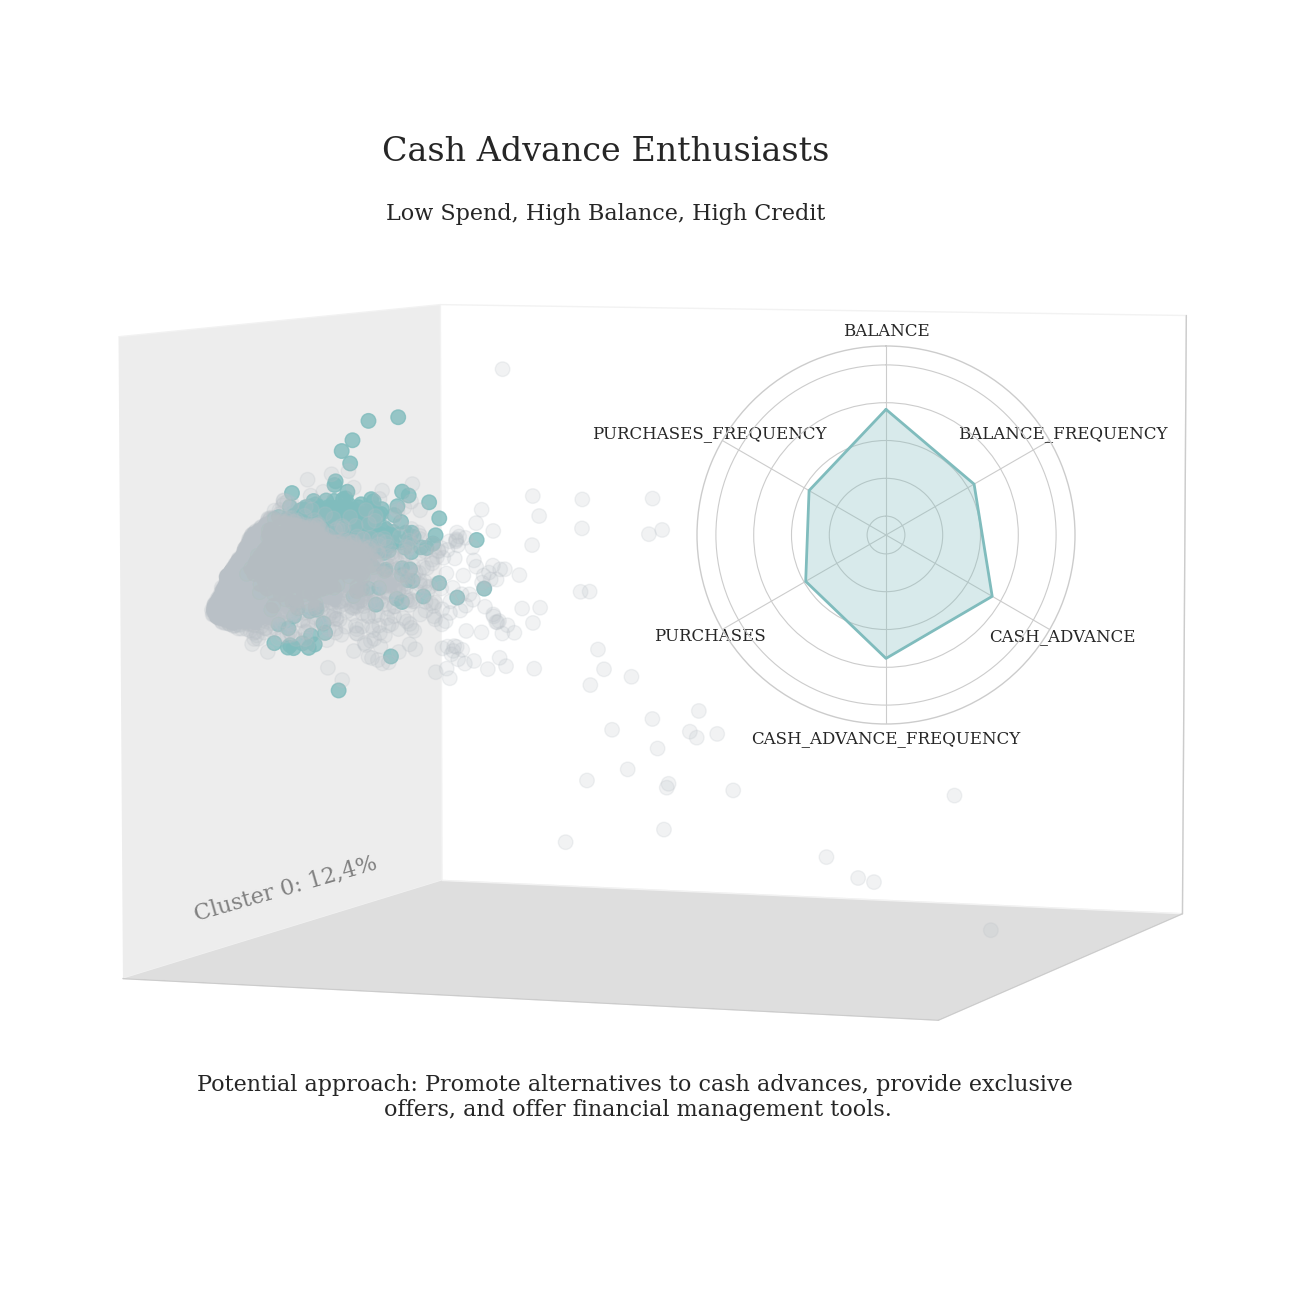

In [96]:
# Initialize the figure with gridspec
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[2, 2])

# Define subplots
ax_pca = fig.add_subplot(gs[0, 0], projection='3d')
ax_rad = fig.add_subplot(gs[0, 0], polar=True)

ax_pca.set_position([0.05, 0.05, 0.96, 0.92])
ax_rad.set_position([0.54, 0.46, 0.27, 0.27])

# Store the text objects for clearing it later
figtext_obj1 = None
figtext_obj2 = None
figtext_obj3 = None

# Animation function
steps_per_transition = 50  # Total frames per cluster display/transition
transition_steps = 15       # Number of frames dedicated to radar chart transition
static_steps = steps_per_transition - transition_steps  # Static display frames

def update(frame):
    global figtext_obj1
    global figtext_obj2
    global figtext_obj3

    ax_pca.cla()  # Clear PCA plot
    ax_rad.cla()  # Clear radar chart

    # Determine current cluster and next cluster
    cluster_id = frame // steps_per_transition
    next_cluster_id = (cluster_id + 1) % len(cluster_means)
    alpha_all = 0.2
    # Determine if the frame is static or transitioning
    step_in_transition = frame % steps_per_transition

    if step_in_transition < static_steps:
        # Static phase: current cluster fully visible
        alpha_cluster = 0.8
        radar_chart(ax_rad, cluster_id, cluster_id, 0, 1)  # No transition
        plot_pca(ax_pca, cluster_id, alpha_cluster, alpha_all)

    else:
        # Transition phase: interpolate between current and next cluster
        t = (step_in_transition - static_steps) / transition_steps  # Normalized transition step [0, 1]
        alpha_cluster = 0.8 * (1 - t)  # Fade out current cluster
        alpha_next_cluster = 0.8 * t  # Fade in next cluster
        # alpha_all = 0.1 + 0.1 * t  # Adjust global alpha slightly

        # Radar chart interpolation
        radar_chart(ax_rad, cluster_id, next_cluster_id, step_in_transition - static_steps, transition_steps)

        # PCA plot interpolation
        plot_pca(ax_pca, cluster_id, alpha_cluster, alpha_all)
        plot_pca(ax_pca, next_cluster_id, alpha_next_cluster, alpha_all)

    # Update title and strategy text
    fig.suptitle(f"{cluster_names[cluster_id][0]}", fontsize=24, y=0.88)

    # Update cluster descriptions
    if figtext_obj1 is not None:
        figtext_obj1.remove()
    if figtext_obj2 is not None:
        figtext_obj2.remove()
    if figtext_obj3 is not None:
        figtext_obj3.remove()

    # cluster percent
    figtext_obj1 = plt.figtext(0.30, 0.32, f"Cluster {cluster_id}: {percent[cluster_id]}", ha="center", fontsize=16, rotation=16, c='grey')
    # possible strategy
    figtext_obj2 = plt.figtext(0.52, 0.18, cluster_strategies[cluster_id], ha="center", fontsize=16)
    # subtitle
    figtext_obj3 = plt.figtext(0.5, 0.82, cluster_names[cluster_id][1], ha="center", fontsize=16)



# Total frames for the animation
total_frames = len(cluster_means) * steps_per_transition

ani = FuncAnimation(fig, update, frames=total_frames, repeat=False)

# # Save animation as GIF
ani.save("RAD_Transition.gif", writer='pillow', fps=10, dpi=100, savefig_kwargs={"bbox_inches": "tight", "facecolor": "white"})
